In [1]:
#For accessing files
import os
import glob

#For Images
import cv2
import matplotlib.pyplot as plt
import numpy as np

#For checking progress
from tqdm import tqdm_notebook

import datetime

#PyTorch Packages
import torch
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

In [2]:
def get_image(path,transform=False):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if transform:
        img = transform(img)
    return img

def show_data(rows,cols,data,transform=False):
    path = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/{}/'.format(data)
    path = os.path.join(path,'*','*.png')
    img_paths = glob.glob(path)
    np.random.seed(0)
    img_paths = np.random.choice(img_paths,rows*cols)
    fig = plt.figure(figsize=(8,8),dpi=150)
    i = 1
    for r in range(rows):
        for c in range(cols):
            image_path = img_paths[i-1]
            if 'fresh' in image_path.split('/')[-2]:
                title = 'Fresh'
            else:
                title = 'Rotten'
            ax = fig.add_subplot(rows,cols,i)
            img = get_image(image_path,transform)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(title,fontsize=5)
            ax.imshow(img)
            i+=1
    return fig

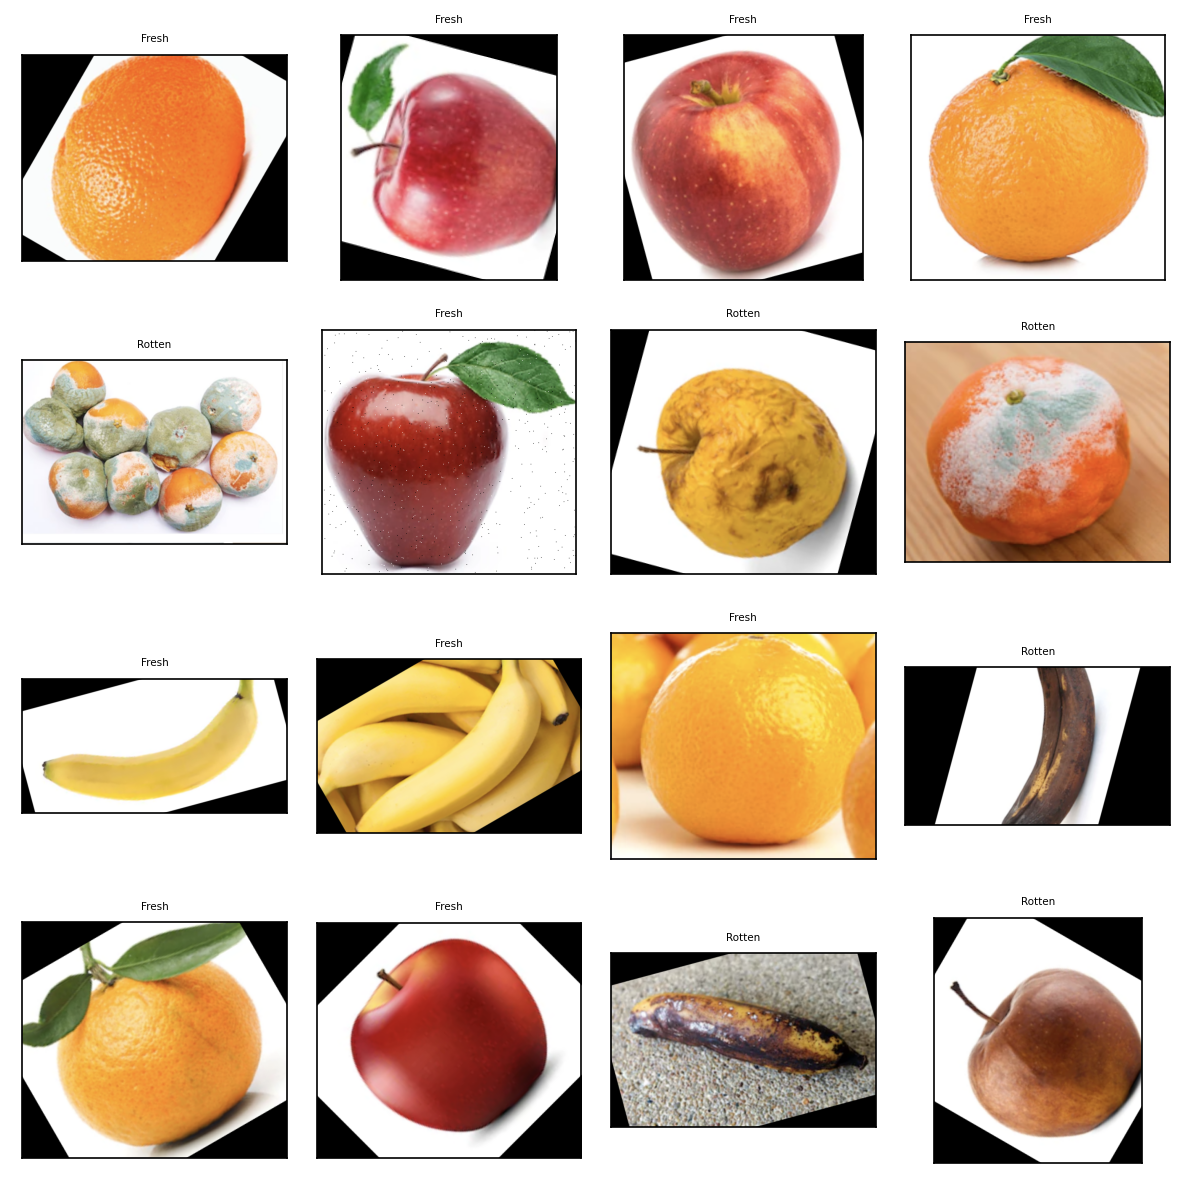

In [3]:
fig = show_data(4,4,'train')
fig.tight_layout()

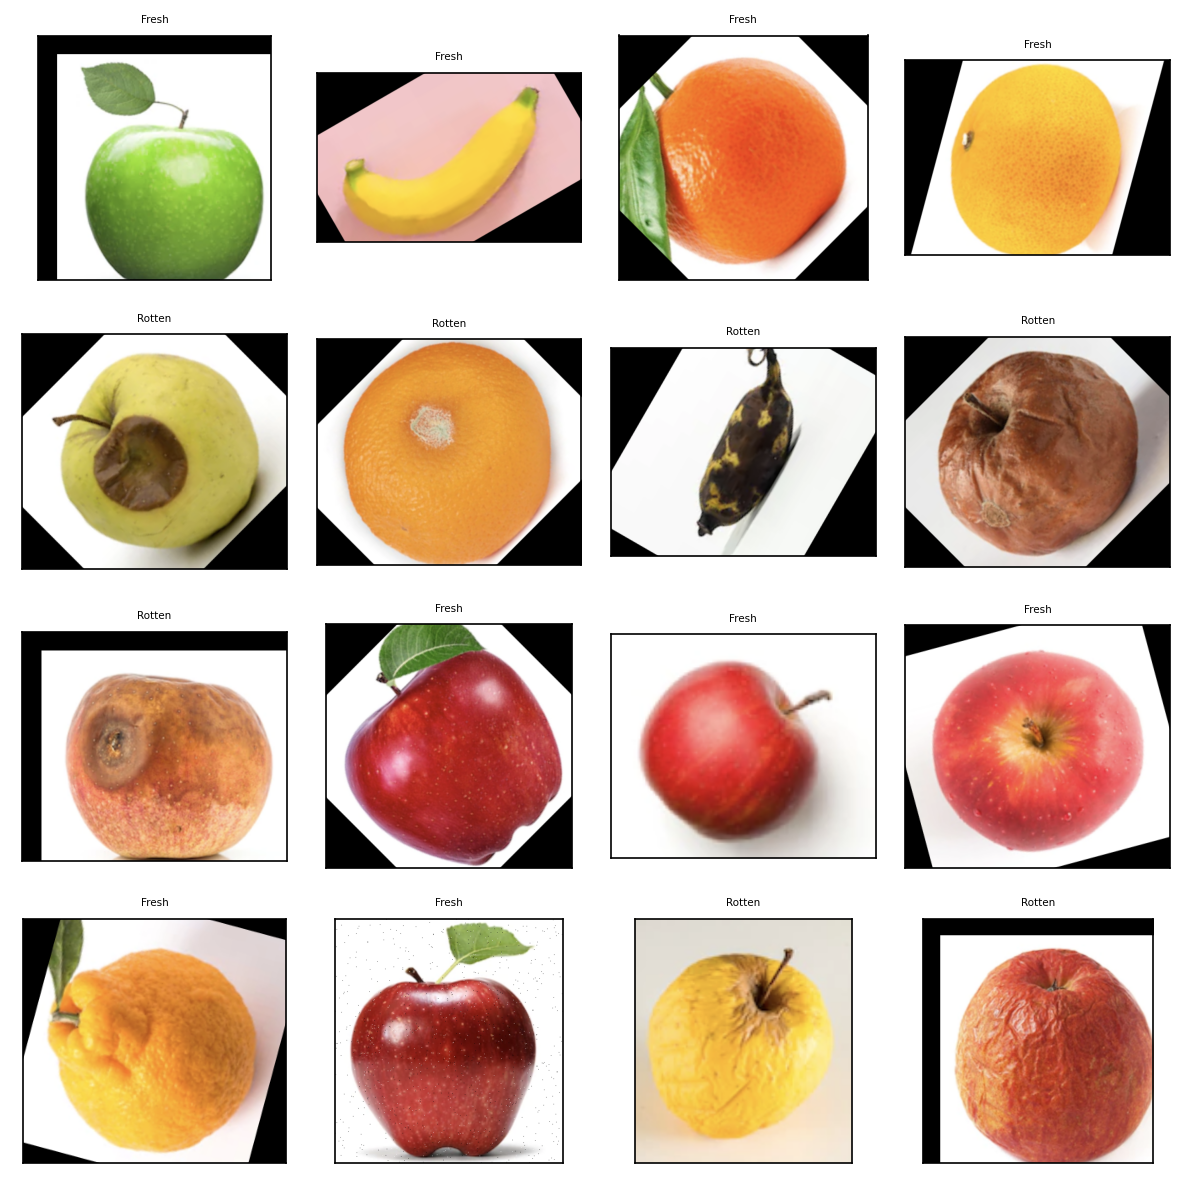

In [4]:
fig = show_data(4,4,'test')
fig.tight_layout()

In [5]:
class FruitsDataset(Dataset):
    def __init__(self,path,subset='train',transforms=None):
        self.subset = subset
        if self.subset == 'train':
            self.PATH = os.path.join(path,'train','*','*.png')
        elif self.subset == 'test':
            self.PATH = os.path.join(path,'test','*','*.png')
        self.data = glob.glob(self.PATH)
        self.height = 32
        self.width = 32
        self.labels = [] 
        classes = ['fresh','rotten']
        for fruit in self.data:
            if classes[0] in fruit.split('/')[-2]:
                self.labels.append(0)
            else:
                self.labels.append(1)

        self.transforms = transforms
      
    def __getitem__(self,index):
        img_path = self.data[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(self.width,self.height))
        label = self.labels[index]
        if self.transforms is not None:
            img_as_tensor = self.transforms(img)
            if self.transforms is not None:
                return(img_as_tensor,label)
            return(img,label)
  
    def __len__(self):
        return(len(self.data))

In [6]:
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.7321, 0.6322, 0.5291),
        (0.3302, 0.3432, 0.3701))
])
dataset = FruitsDataset('/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/',transforms = transformations)

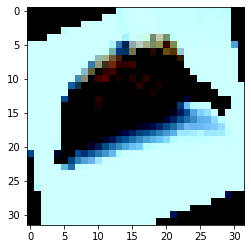

In [7]:
img_t, _ = dataset[1000]
img = img_t.permute(1,2,0)
plt.imshow(img);

In [8]:
batch_size = 64
validation_split = .2
shuffle_dataset = True
random_seed= 1

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [9]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(16,8,kernel_size=3,padding=1)
        self.fc1 = nn.Linear(8*8*8,32)
        self.fc2 = nn.Linear(32,2)
    def forward(self,x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
        out = out.view(-1,8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [10]:
model = Model()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [11]:
device = (torch.device('cuda') if torch.cuda.is_available()
  else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [12]:
def training_loop(n_epochs,optimizer,model,loss_fn,train_loader):
    for epoch in tqdm_notebook(range(1,n_epochs+1)):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs,labels)
            #get rid of gradients from last round
            optimizer.zero_grad()
            #performs backward step. Computes all the gradients
            loss.backward()
            #Updates the model
            optimizer.step()
            loss_train += loss.item()
        print('{} Epoch {}, Training Loop {}'.format(
          datetime.datetime.now(), epoch, loss_train/len(train_loader)))

model = Model().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop(
  n_epochs = 50,
  optimizer = optimizer,
  model = model,
  loss_fn = loss_fn,
  train_loader = train_loader,
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/50 [00:00<?, ?it/s]

2021-03-21 08:30:52.199709 Epoch 1, Training Loop 0.613603278233187
2021-03-21 08:31:36.841883 Epoch 2, Training Loop 0.4969339949371171
2021-03-21 08:32:21.840292 Epoch 3, Training Loop 0.4642394054545103
2021-03-21 08:33:06.279102 Epoch 4, Training Loop 0.43357229145774007
2021-03-21 08:33:51.138242 Epoch 5, Training Loop 0.4013795441519605
2021-03-21 08:34:35.636396 Epoch 6, Training Loop 0.3723367243787668
2021-03-21 08:35:20.264637 Epoch 7, Training Loop 0.3451343721499408
2021-03-21 08:36:05.665627 Epoch 8, Training Loop 0.32301830668954085
2021-03-21 08:36:49.993788 Epoch 9, Training Loop 0.30340346411196856
2021-03-21 08:37:34.333264 Epoch 10, Training Loop 0.2872421422796528
2021-03-21 08:38:19.223464 Epoch 11, Training Loop 0.27340811866260795
2021-03-21 08:39:03.825124 Epoch 12, Training Loop 0.2624871642158849
2021-03-21 08:39:48.534674 Epoch 13, Training Loop 0.25049053148849165
2021-03-21 08:40:33.080411 Epoch 14, Training Loop 0.24107619935143604
2021-03-21 08:41:18.0135

In [13]:
torch.save(model.state_dict(), 'FruitHealthDetector.pt')

In [14]:
def validate(model,train_loader,val_loader):
    for name, loader in [('train',train_loader),('val',validation_loader)]:
        correct = 0
        total = 0

        #gradients nor required, as we don't want to train our parameters
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                #max_index,value
                _,predicted = torch.max(outputs,dim=1)
                total+=labels.shape[0]
                correct+=int((predicted==labels).sum())
    
        print('Accuracy {}: {:.2f}'.format(name, correct/total))

validate(model,train_loader,validation_loader)

Accuracy train: 0.96
Accuracy val: 0.95


Actual: 1
Prediction: tensor([[-0.9875,  0.2269]], device='cuda:0', grad_fn=<AddmmBackward>)


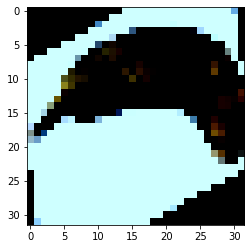

In [15]:
img,label = dataset[1]
plt.imshow(img.permute(1,2,0))
out = model(img.unsqueeze(0).to(device))
print('Actual: {}'.format(label))
print('Prediction: {}'.format(out))

In [16]:
transformations_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.7369, 0.6360, 0.5318),
        (0.3281, 0.3417, 0.3704))
])
test = FruitsDataset('/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/',subset='test',transforms=transformations_test)

Prediction: tensor([[2.7400e-04, 9.9973e-01]], device='cuda:0', grad_fn=<SoftmaxBackward>)


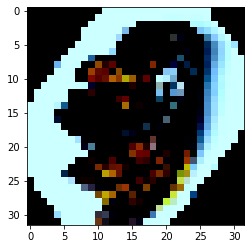

In [17]:
img,_ = test[400]
plt.imshow(img.permute(1,2,0))
s = nn.Softmax(dim=1)
out = s(model(img.unsqueeze(0).to(device)))
print('Prediction: {}'.format(out))

In [18]:
correct = 0
total = 0
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size)
for imgs, labels in train_loader:
    imgs = imgs.to(device=device)
    labels = labels.to(device=device)
    out = model(imgs)
    _,predicted = torch.max(out,dim=1)
    correct += int((predicted==labels).sum())
    total += len(labels)

In [19]:
(correct/total)*100

95.65416809998854

In [22]:
# Input to the model
x = torch.randn(batch_size, 3, 32, 32, requires_grad=True).to(device=device)
output = model(x)

# Export the model
torch.onnx.export(model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "FruitHealthDetector.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})